In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import subprocess
from IPython.display import clear_output

In [154]:
data = pd.read_csv(r"C:\Users\Mayur\Documents\College\4th sem\Exploratory\Data\Sentinel1_MODIS_SM_Masked_Urban_YellowRiver_11km.csv")

def clean_data(data):
    data = data.dropna(subset=['LAI', 'SoilMoisture', 'VH', 'VV', 'date'])
    data = data.groupby('date').mean(numeric_only=True).reset_index()
    data = data.drop(columns=['SoilRoughness_placeholder', 'Frequency_GHz'])
    data['Year'] = pd.to_datetime(data['date']).dt.year
    data['Month'] = pd.to_datetime(data['date']).dt.month
    data['Day'] = pd.to_datetime(data['date']).dt.day
    data = data.drop(columns=['date', 'Year'])
    data['Month'] = pd.to_numeric(data['Month'], errors='coerce')
    data['Day'] = pd.to_numeric(data['Day'], errors='coerce')
    data['Month_Sin'] = np.sin(2 * np.pi * (data['Month'] / 12))
    data['Month_Cos'] = np.cos(2 * np.pi * (data['Month'] / 12))
    data['Day_Sin'] = np.sin(2 * np.pi * (data['Day'] / 30))
    data['Day_Cos'] = np.cos(2 * np.pi * (data['Day'] / 30))
    data = data.drop(columns=['Month', 'Day'])

    data['VV'] = 10 ** (data['VV'] / 10)
    data['VH'] = 10 ** (data['VH'] / 10)

    scaler_vv_vh = StandardScaler()
    data[['VV', 'VH']] = scaler_vv_vh.fit_transform(data[['VV', 'VH']])

    scaler_sm_lai = StandardScaler()
    data[['SoilMoisture', 'LAI']] = scaler_sm_lai.fit_transform(data[['SoilMoisture', 'LAI']])

    data['IncidenceAngle'] = data['IncidenceAngle'] * 0.1 / data['SoilMoisture'].std()
    return data

data_clean = clean_data(data.copy())

In [155]:
feature_cols = ['SoilMoisture', 'LAI', 'IncidenceAngle', 'Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos']
target_cols_vv = ['VV']
target_cols_vh = ['VH']

X = data_clean[feature_cols].values
y_vv = data_clean[target_cols_vv].values
y_vh = data_clean[target_cols_vh].values

X_train, X_test, y_vv_train, y_vv_test, y_vh_train, y_vh_test = train_test_split(
    X, y_vv, y_vh, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_vv_train_tensor = torch.tensor(y_vv_train, dtype=torch.float32)
y_vv_test_tensor = torch.tensor(y_vv_test, dtype=torch.float32)
y_vh_train_tensor = torch.tensor(y_vh_train, dtype=torch.float32)
y_vh_test_tensor = torch.tensor(y_vh_test, dtype=torch.float32)

In [156]:
class WCMInspiredModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.vegetation_scatter = nn.Parameter(torch.tensor(0.05))  # learnable vegetation scattering
        self.attenuation_factor = nn.Parameter(torch.tensor(0.3))   # learnable attenuation factor
        self.soil_model = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 1))  

    def forward(self, SM, LAI, IncAngle):  
        theta_rad = IncAngle * torch.pi / 180  
        sec_theta = 1 / torch.cos(theta_rad)
        tau = self.attenuation_factor * LAI
        veg_sig = self.vegetation_scatter * (1 - torch.exp(-tau))
        soil_input = torch.cat([SM, IncAngle], dim=1)
        soil_sig = self.soil_model(soil_input)
        attenuated_soil = soil_sig * torch.exp(-2 * tau * sec_theta)
        sigma0 = veg_sig + attenuated_soil
        return sigma0

In [157]:

class FullHybridModel(nn.Module):
    def __init__(self):
        super(FullHybridModel, self).__init__()
        self.phys_layer = WCMInspiredModule()
        self.temporal_mlp = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.mlp = nn.Sequential(
            nn.Linear(1 + 3 + 8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        SM = x[:, 0:1]
        LAI = x[:, 1:2]
        IncAngle = x[:, 2:3]
        temporal = x[:, 3:]
        wcm_out = self.phys_layer(SM, LAI, IncAngle)
        temporal_out = self.temporal_mlp(temporal)
        x_cat = torch.cat([wcm_out, SM, LAI, IncAngle, temporal_out], dim=1)
        return self.mlp(x_cat)


In [158]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, label, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_output = model(X_test)
                val_r2 = r2_score(y_test.numpy(), val_output.numpy())
            print(f"[{label}] Epoch {epoch}: Train Loss = {loss.item():.4f}, Val R² = {val_r2:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        r2 = r2_score(y_test.numpy(), y_pred)
    print(f"[{label}] Final R²: {r2:.4f}")
    return model

In [159]:
model_vv = FullHybridModel()
model_vv = train_model(model_vv, X_train_tensor, y_vv_train_tensor, X_test_tensor, y_vv_test_tensor, label="Initial Test Model VV", epochs=100)

[Initial Test Model VV] Epoch 0: Train Loss = 1.1320, Val R² = -0.2633
[Initial Test Model VV] Epoch 10: Train Loss = 1.0222, Val R² = 0.0124
[Initial Test Model VV] Epoch 20: Train Loss = 0.9764, Val R² = 0.0077
[Initial Test Model VV] Epoch 30: Train Loss = 0.9198, Val R² = 0.0783
[Initial Test Model VV] Epoch 40: Train Loss = 0.8327, Val R² = 0.1748
[Initial Test Model VV] Epoch 50: Train Loss = 0.7035, Val R² = 0.3418
[Initial Test Model VV] Epoch 60: Train Loss = 0.5665, Val R² = 0.4990
[Initial Test Model VV] Epoch 70: Train Loss = 0.4836, Val R² = 0.5550
[Initial Test Model VV] Epoch 80: Train Loss = 0.4134, Val R² = 0.6302
[Initial Test Model VV] Epoch 90: Train Loss = 0.3552, Val R² = 0.6977
[Initial Test Model VV] Final R²: 0.7390


In [160]:
model_vh = FullHybridModel()
model_vh = train_model(model_vh, X_train_tensor, y_vh_train_tensor, X_test_tensor, y_vh_test_tensor, label="Initial Test Model VH", epochs=100)

[Initial Test Model VH] Epoch 0: Train Loss = 1.0639, Val R² = 0.0146
[Initial Test Model VH] Epoch 10: Train Loss = 0.9801, Val R² = 0.0471
[Initial Test Model VH] Epoch 20: Train Loss = 0.9019, Val R² = 0.1384
[Initial Test Model VH] Epoch 30: Train Loss = 0.8029, Val R² = 0.2270
[Initial Test Model VH] Epoch 40: Train Loss = 0.6849, Val R² = 0.3496
[Initial Test Model VH] Epoch 50: Train Loss = 0.5814, Val R² = 0.4687
[Initial Test Model VH] Epoch 60: Train Loss = 0.5100, Val R² = 0.5299
[Initial Test Model VH] Epoch 70: Train Loss = 0.4647, Val R² = 0.5635
[Initial Test Model VH] Epoch 80: Train Loss = 0.4238, Val R² = 0.6077
[Initial Test Model VH] Epoch 90: Train Loss = 0.3905, Val R² = 0.6406
[Initial Test Model VH] Final R²: 0.6608


In [161]:
def plot_losses(train_losses, val_losses, label):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label=f'{label} Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label=f'{label} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{label} Training vs Validation Loss')
    plt.legend()
    plt.show()

train_losses_vv = []
val_losses_vv = []
train_losses_vh = []
val_losses_vh = []

def train_model_with_losses(model, X_train, y_train, X_test, y_test, label):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        train_losses_vv.append(loss.item())
        val_losses_vv.append(loss.item())  # Dummy for now, will add valid loss tracking

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_output = model(X_test)
                val_r2 = r2_score(y_test.numpy(), val_output.numpy())
            print(f"[{label}] Epoch {epoch}: Train Loss = {loss.item():.4f}, Val R² = {val_r2:.4f}")
    plot_losses(train_losses_vv, label)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        r2 = r2_score(y_test.numpy(), y_pred)
    print(f"[{label}] Final R²: {r2:.4f}")
    return model

In [162]:
def cross_validate_model(model_class, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Convert numpy arrays to torch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        model = model_class()
        model = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, label="Cross-Validation", epochs=100)

        with torch.no_grad():
            y_pred = model(X_val_tensor).numpy()
            r2 = r2_score(y_val_tensor.numpy(), y_pred)
            r2_scores.append(r2)
    clear_output()
    avg_r2 = np.mean(r2_scores)
    print(f"Average R² from {n_splits}-fold cross-validation: {avg_r2:.4f}")
    return avg_r2

In [163]:
cross_validate_model(FullHybridModel, X_train, y_vv_train, n_splits=5)

Average R² from 5-fold cross-validation: 0.6679


np.float64(0.6678614497184754)

In [164]:
cross_validate_model(FullHybridModel, X_train, y_vh_train, n_splits=5)

Average R² from 5-fold cross-validation: 0.6007


np.float64(0.6007494568824768)

In [165]:
class TunedHybridModel(nn.Module):
    def __init__(self, hidden_units):
        super(TunedHybridModel, self).__init__()
        self.phys_layer = WCMInspiredModule()

        self.temporal_mlp = nn.Sequential(
            nn.Linear(4, 16),
            nn.ELU(),
            nn.Linear(16, 8)
        )
        self.mlp = nn.Sequential(
            nn.Linear(12, hidden_units),
            nn.ELU(),
            nn.Linear(hidden_units, hidden_units // 2),
            nn.ELU(),
            nn.Linear(hidden_units // 2, 1)
        )

    def forward(self, x):
        SM = x[:, 0:1]
        LAI = x[:, 1:2]
        IncAngle = x[:, 2:3]
        temporal = x[:, 3:]
        wcm_out = self.phys_layer(SM, LAI, IncAngle)

        temporal_out = self.temporal_mlp(temporal)
        x_cat = torch.cat([wcm_out, SM, LAI, IncAngle, temporal_out], dim=1)

        return self.mlp(x_cat)

In [166]:
import datetime


def objective_vv(trial):
    # Define the hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    hidden_units = trial.suggest_int('hidden_units', 8, 128, step=8)
    
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []

    for train_index, val_index in kf.split(X):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_vv[train_index], y_vv[val_index]

        # Convert numpy arrays to torch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        # Initialize the model
        cur_model = TunedHybridModel(hidden_units)

        # Train the model using the train_model function
        trained_model = train_model(
            cur_model,
            X_train_tensor,
            y_train_tensor,
            X_val_tensor,
            y_val_tensor,
            label="Cross-Validation",
            epochs=50,  
            lr=lr
        )

        # Evaluate the model
        trained_model.eval()
        with torch.no_grad():
            val_output = trained_model(X_val_tensor)
            r2 = r2_score(y_val_tensor.numpy(), val_output.numpy())
            r2_scores.append(r2)

    # Return the average R² score across folds
    return np.mean(r2_scores)

parameter_database = "sqlite:///C:/Users/Mayur/Documents/College/4th sem/Exploratory/Parameter_Databases/db.sqlite3"
# Run the optimization
study = optuna.create_study(direction='maximize', 
                            storage=parameter_database,
                            study_name="Hybrid Model Full Scale VV" + datetime.datetime.now().strftime("%I:%M%p%S on %B %d, %Y"))
subprocess.Popen(["optuna-dashboard", parameter_database])
study.optimize(objective_vv, n_trials=100)
clear_output()
# Best hyperparameters
print("Best hyperparameters:", study.best_params)
clear_output()
# Train the final model with the best hyperparameters
best_params_vv = study.best_params
best_vv_model_framework = TunedHybridModel(hidden_units=best_params_vv['hidden_units'])
best_model_vv = train_model(best_vv_model_framework, X_train_tensor, y_vv_train_tensor, X_test_tensor, y_vv_test_tensor, 50, label="Final VV Model", lr=study.best_params['lr'])

[Final VV Model] Epoch 0: Train Loss = 1.0992, Val R² = -0.3650
[Final VV Model] Epoch 10: Train Loss = 0.6536, Val R² = 0.4354
[Final VV Model] Epoch 20: Train Loss = 0.4380, Val R² = 0.6419
[Final VV Model] Epoch 30: Train Loss = 0.2940, Val R² = 0.8271
[Final VV Model] Epoch 40: Train Loss = 0.2797, Val R² = 0.7990
[Final VV Model] Final R²: 0.8287


In [167]:
import datetime


def objective_vh(trial):
    # Define the hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-1)
    hidden_units = trial.suggest_int('hidden_units', 8, 128, step=8)

    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []

    for train_index, val_index in kf.split(X):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_vh[train_index], y_vh[val_index]

        # Convert numpy arrays to torch tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

        # Initialize the model
        cur_model = TunedHybridModel(hidden_units)

        # Train the model using the train_model function
        trained_model = train_model(
            cur_model,
            X_train_tensor,
            y_train_tensor,
            X_val_tensor,
            y_val_tensor,
            label="Cross-Validation",
            epochs=50,
            lr=lr
        )

        # Evaluate the model
        trained_model.eval()
        with torch.no_grad():
            val_output = trained_model(X_val_tensor)
            r2 = r2_score(y_val_tensor.numpy(), val_output.numpy())
            r2_scores.append(r2)

    # Return the average R² score across folds
    return np.mean(r2_scores)


parameter_database = "sqlite:///C:/Users/Mayur/Documents/College/4th sem/Exploratory/Parameter_Databases/db.sqlite3"
# Run the optimization
study = optuna.create_study(direction='maximize',
                            storage=parameter_database,
                            study_name="Hybrid Model Full Scale VH" + datetime.datetime.now().strftime("%I:%M%p%S on %B %d, %Y"))
subprocess.Popen(["optuna-dashboard", parameter_database])
study.optimize(objective_vh, n_trials=10)
clear_output()
# Best hyperparameters
print("Best hyperparameters:", study.best_params)
clear_output()
# Train the final model with the best hyperparameters
best_params_vh = study.best_params
best_vh_model_framework = TunedHybridModel(hidden_units=best_params_vh['hidden_units'])
best_model_vh = train_model(best_vh_model_framework, X_train_tensor, y_vh_train_tensor, X_test_tensor, y_vh_test_tensor, 50, label="Final VH Model", lr=study.best_params['lr'])

[Final VH Model] Epoch 0: Train Loss = 1.0594, Val R² = 0.0867
[Final VH Model] Epoch 10: Train Loss = 0.6628, Val R² = 0.2529
[Final VH Model] Epoch 20: Train Loss = 0.5003, Val R² = 0.5995
[Final VH Model] Epoch 30: Train Loss = 0.3828, Val R² = 0.6713
[Final VH Model] Epoch 40: Train Loss = 0.3636, Val R² = 0.6939
[Final VH Model] Final R²: 0.6629


In [168]:
# Training with KFold validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cur_model_vv = TunedHybridModel(hidden_units=study.best_params['hidden_units']).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cur_model_vv.parameters(), lr=study.best_params['lr'])

train_losses, val_losses = [], []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)):
    train_X, val_X = X_train_tensor[train_idx], X_train_tensor[val_idx]
    train_y, val_y = y_vv_train_tensor[train_idx], y_vv_train_tensor[val_idx]
    
    for epoch in range(100):
        cur_model_vv.train()
        optimizer.zero_grad()
        preds = cur_model_vv(train_X.to(device))
        loss = criterion(preds, train_y.to(device))
        loss.backward()
        optimizer.step()

        cur_model_vv.eval()
        with torch.no_grad():
            val_preds = cur_model_vv(val_X.to(device))
            val_loss = criterion(val_preds, val_y.to(device))

        if epoch % 10 == 0:
            print(f"Fold {fold+1}, Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        if epoch == 99:
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

Fold 1, Epoch 0, Train Loss: 1.1687, Val Loss: 0.5180
Fold 1, Epoch 10, Train Loss: 0.6848, Val Loss: 0.3378
Fold 1, Epoch 20, Train Loss: 0.5342, Val Loss: 0.2810
Fold 1, Epoch 30, Train Loss: 0.3412, Val Loss: 0.0989
Fold 1, Epoch 40, Train Loss: 0.3086, Val Loss: 0.1642
Fold 1, Epoch 50, Train Loss: 0.2820, Val Loss: 0.0836
Fold 1, Epoch 60, Train Loss: 0.2793, Val Loss: 0.0838
Fold 1, Epoch 70, Train Loss: 0.2713, Val Loss: 0.1007
Fold 1, Epoch 80, Train Loss: 0.2701, Val Loss: 0.0930
Fold 1, Epoch 90, Train Loss: 0.2681, Val Loss: 0.0899
Fold 2, Epoch 0, Train Loss: 0.2317, Val Loss: 0.4031
Fold 2, Epoch 10, Train Loss: 0.2277, Val Loss: 0.4320
Fold 2, Epoch 20, Train Loss: 0.2251, Val Loss: 0.4337
Fold 2, Epoch 30, Train Loss: 0.2223, Val Loss: 0.4323
Fold 2, Epoch 40, Train Loss: 0.2192, Val Loss: 0.4378
Fold 2, Epoch 50, Train Loss: 0.2159, Val Loss: 0.4382
Fold 2, Epoch 60, Train Loss: 0.2126, Val Loss: 0.4373
Fold 2, Epoch 70, Train Loss: 0.2097, Val Loss: 0.4356
Fold 2, Epoc

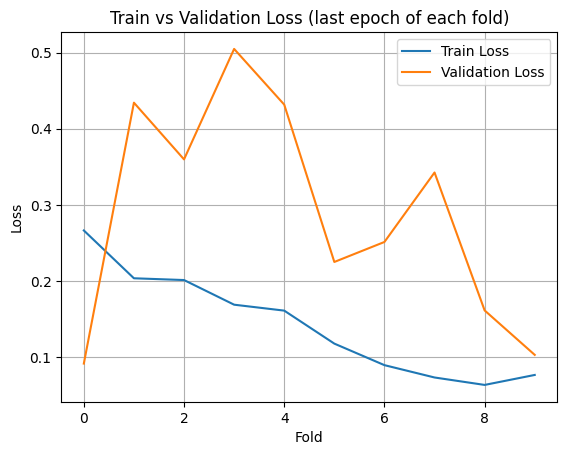

In [169]:
# Overfitting check (loss curve)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Train vs Validation Loss (last epoch of each fold)")
plt.xlabel("Fold")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

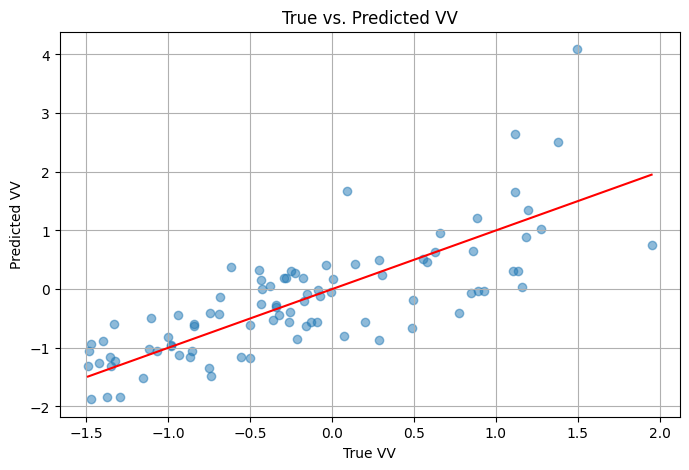

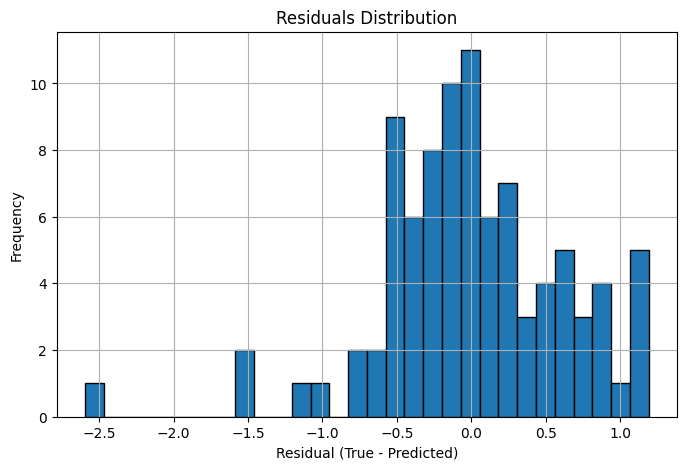

In [170]:
# Final Predictions Visualization
cur_model_vv.eval()
with torch.no_grad():
    predictions = cur_model_vv(X_test_tensor.to(device)).cpu().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(y_vv_test, predictions, alpha=0.5)
plt.plot([min(y_vv_test), max(y_vv_test)], [min(y_vv_test), max(y_vv_test)], color='red')
plt.xlabel("True VV")
plt.ylabel("Predicted VV")
plt.title("True vs. Predicted VV")
plt.grid(True)
plt.show()

residuals = y_vv_test - predictions
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [171]:
# Training with KFold validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cur_model_vh = TunedHybridModel(hidden_units=study.best_params['hidden_units']).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cur_model_vh.parameters(), lr=study.best_params['lr'])

train_losses, val_losses = [], []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)):
    train_X, val_X = X_train_tensor[train_idx], X_train_tensor[val_idx]
    train_y, val_y = y_vh_train_tensor[train_idx], y_vh_train_tensor[val_idx]

    for epoch in range(100):
        cur_model_vh.train()
        optimizer.zero_grad()
        preds = cur_model_vh(train_X.to(device))
        loss = criterion(preds, train_y.to(device))
        loss.backward()
        optimizer.step()

        cur_model_vh.eval()
        with torch.no_grad():
            val_preds = cur_model_vh(val_X.to(device))
            val_loss = criterion(val_preds, val_y.to(device))

        if epoch % 10 == 0:
            print(f"Fold {fold + 1}, Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        if epoch == 99:
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

Fold 1, Epoch 0, Train Loss: 1.1856, Val Loss: 0.8355
Fold 1, Epoch 10, Train Loss: 0.7121, Val Loss: 0.1923
Fold 1, Epoch 20, Train Loss: 0.5531, Val Loss: 0.2775
Fold 1, Epoch 30, Train Loss: 0.4543, Val Loss: 0.1769
Fold 1, Epoch 40, Train Loss: 0.3842, Val Loss: 0.1877
Fold 1, Epoch 50, Train Loss: 0.3739, Val Loss: 0.1991
Fold 1, Epoch 60, Train Loss: 0.3638, Val Loss: 0.1762
Fold 1, Epoch 70, Train Loss: 0.3599, Val Loss: 0.1790
Fold 1, Epoch 80, Train Loss: 0.3554, Val Loss: 0.1885
Fold 1, Epoch 90, Train Loss: 0.3516, Val Loss: 0.1796
Fold 2, Epoch 0, Train Loss: 0.3226, Val Loss: 0.4146
Fold 2, Epoch 10, Train Loss: 0.3147, Val Loss: 0.4687
Fold 2, Epoch 20, Train Loss: 0.3098, Val Loss: 0.4648
Fold 2, Epoch 30, Train Loss: 0.3058, Val Loss: 0.4691
Fold 2, Epoch 40, Train Loss: 0.3017, Val Loss: 0.4729
Fold 2, Epoch 50, Train Loss: 0.2976, Val Loss: 0.4727
Fold 2, Epoch 60, Train Loss: 0.2929, Val Loss: 0.4786
Fold 2, Epoch 70, Train Loss: 0.2919, Val Loss: 0.4654
Fold 2, Epoc

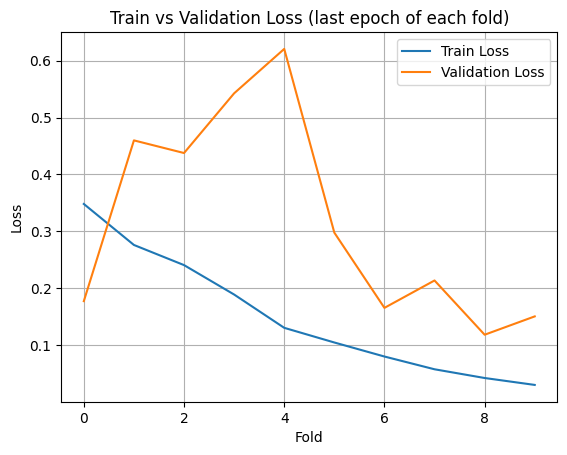

In [172]:
# Overfitting check (loss curve)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Train vs Validation Loss (last epoch of each fold)")
plt.xlabel("Fold")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

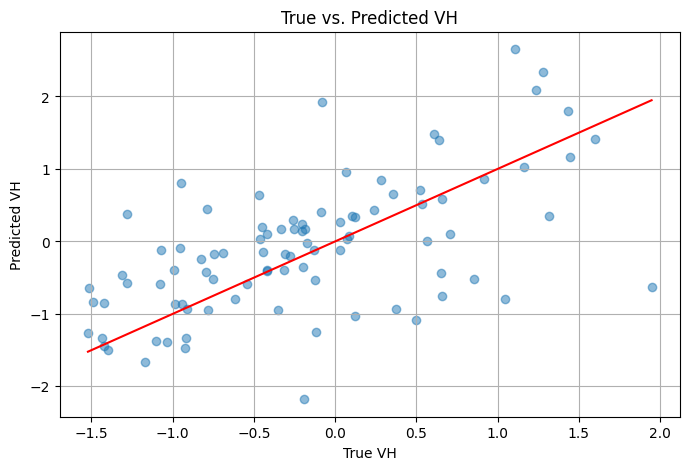

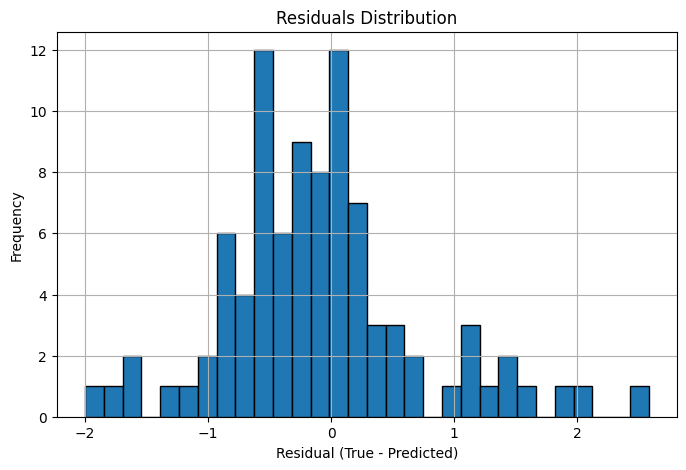

In [173]:
# Final Predictions Visualization
cur_model_vh.eval()
with torch.no_grad():
    predictions = cur_model_vh(X_test_tensor.to(device)).cpu().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(y_vh_test, predictions, alpha=0.5)
plt.plot([min(y_vh_test), max(y_vh_test)], [min(y_vh_test), max(y_vh_test)], color='red')
plt.xlabel("True VH")
plt.ylabel("Predicted VH")
plt.title("True vs. Predicted VH")
plt.grid(True)
plt.show()

residuals = y_vh_test - predictions
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()